In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=65b201c5b785e525923ca2ed1cc0661b7b281445b7fc999d6277f9349517680d
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [3]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools


from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123
import torch, torchvision

In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
|-- TEST
|   |-- NO
|   `-- YES
|-- TRAIN
|   |-- NO
|   `-- YES
`-- VAL
    |-- NO
    `-- YES

9 directories


In [5]:
IMG_PATH = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [6]:
def load_data(dir_path, img_size=(224, 224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img_path = dir_path + path + '/' + file
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Resize the image to the desired shape
                        img = cv2.resize(img, img_size)
                        X.append(img)
                        y.append(i)
                    else:
                        print(f"Failed to load image: {img_path}")
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 108.99it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 29.20it/s]

50 images loaded from VAL/ directory.


In [8]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

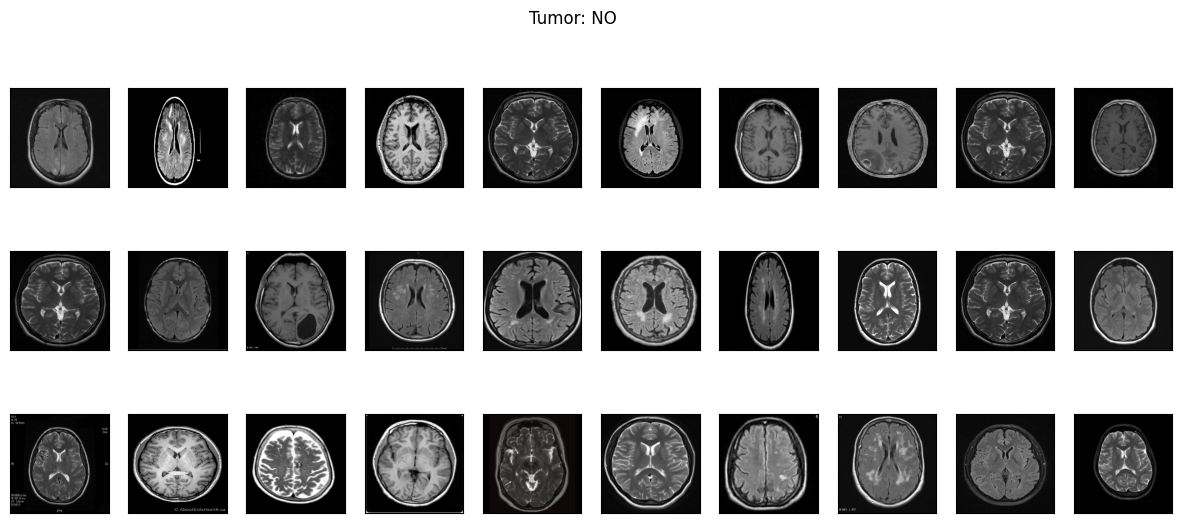

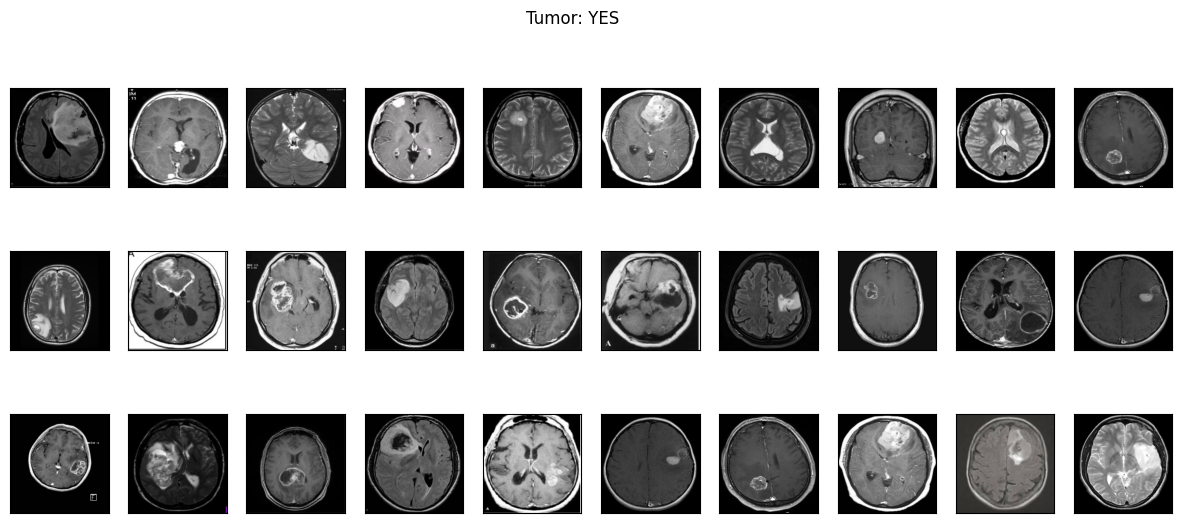

In [9]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

plot_samples(X_train, y_train, labels, 30)

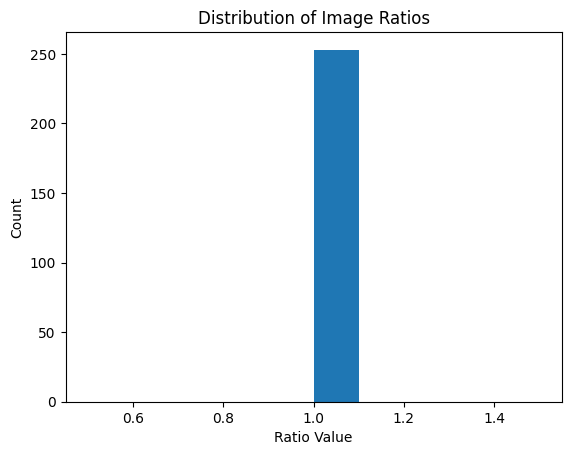

In [10]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [11]:
def crop_imgs(set_name, add_pixels_value=0, target_size=(224, 224)):
    """
    Finds the extreme points on the image and crops the rectangular out of them.
    After cropping, all images will be resized to the same target size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        # Crop the image using the extreme points and add optional padding
        new_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS, 
                      extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()

        # Resize the cropped image to the target size
        new_img_resized = cv2.resize(new_img, target_size)

        # Append the resized image to the set
        set_new.append(new_img_resized)

    # Return the set as a numpy array
    return np.array(set_new)

In [12]:
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

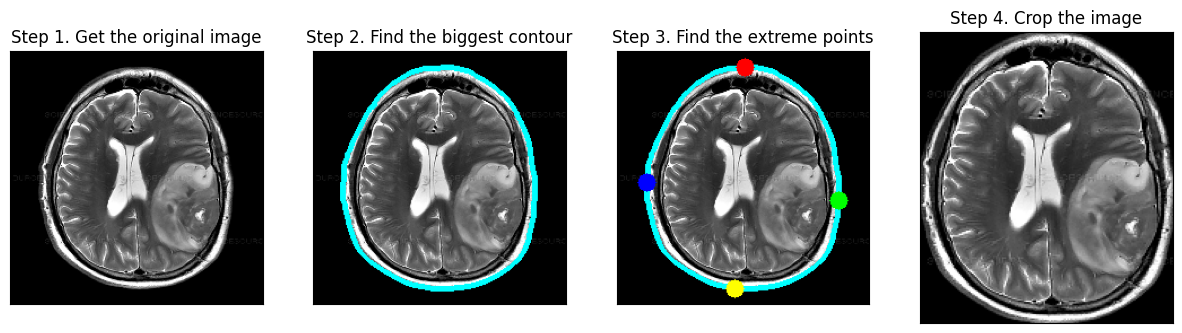

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [14]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

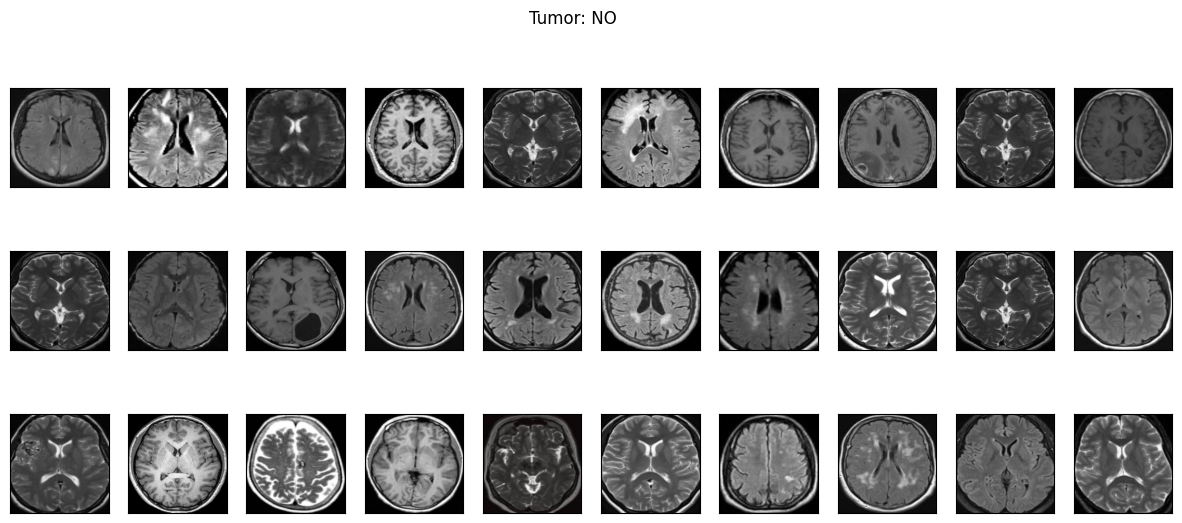

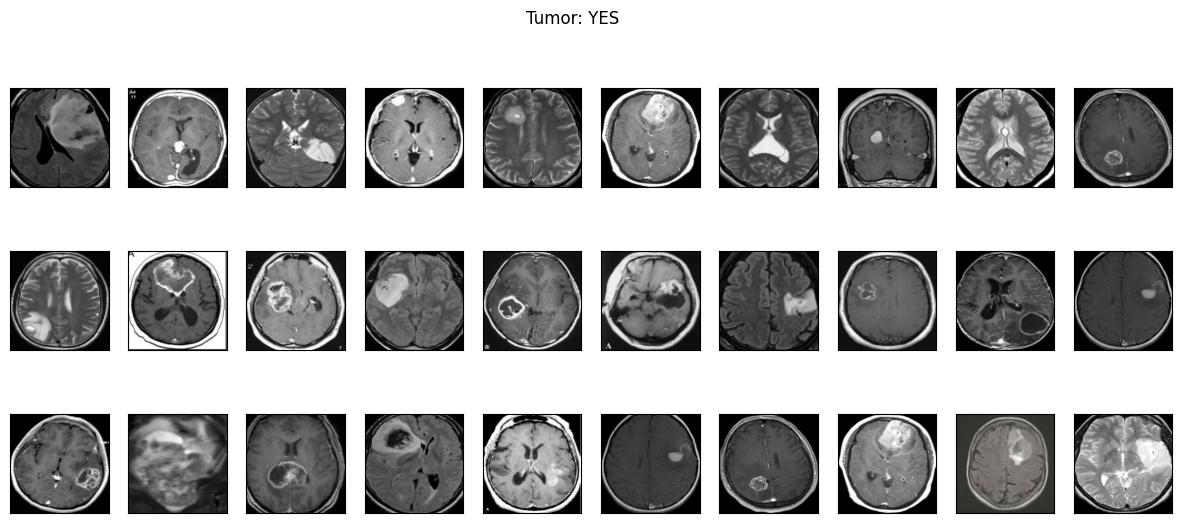

In [15]:
plot_samples(X_train_crop, y_train, labels, 30)

In [16]:
# Create directories if they don't exist
os.makedirs('TRAIN_CROP/YES', exist_ok=True)
os.makedirs('TRAIN_CROP/NO', exist_ok=True)
os.makedirs('TEST_CROP/YES', exist_ok=True)
os.makedirs('TEST_CROP/NO', exist_ok=True)
os.makedirs('VAL_CROP/YES', exist_ok=True)
os.makedirs('VAL_CROP/NO', exist_ok=True)

# Function to save the images
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name + 'NO/' + str(i) + '.jpg', img)
        else:
            cv2.imwrite(folder_name + 'YES/' + str(i) + '.jpg', img)
        i += 1

# Save new images to the folder
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [17]:
from keras.applications.vgg16 import preprocess_input

def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [18]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

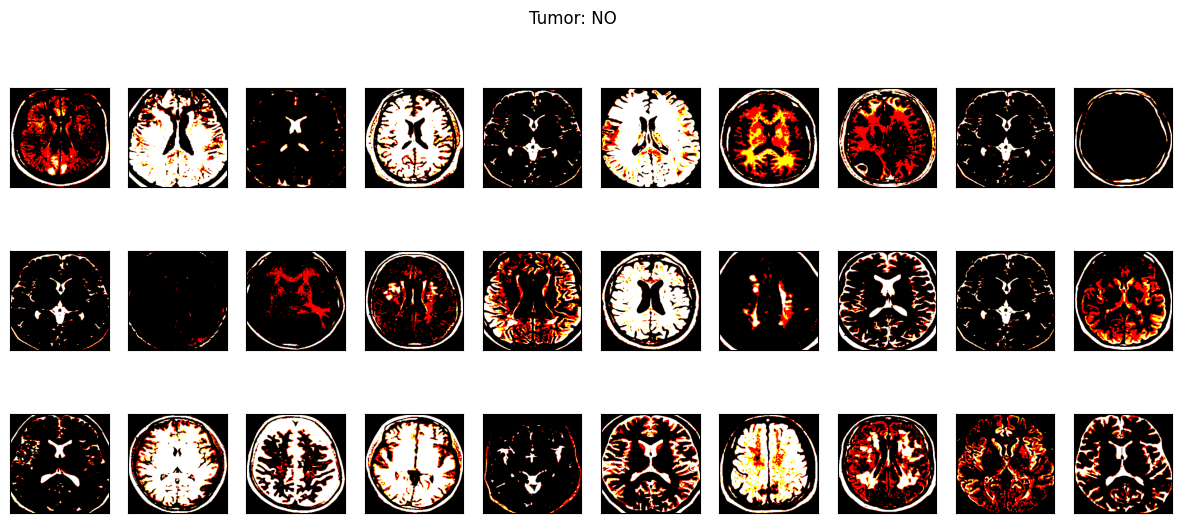

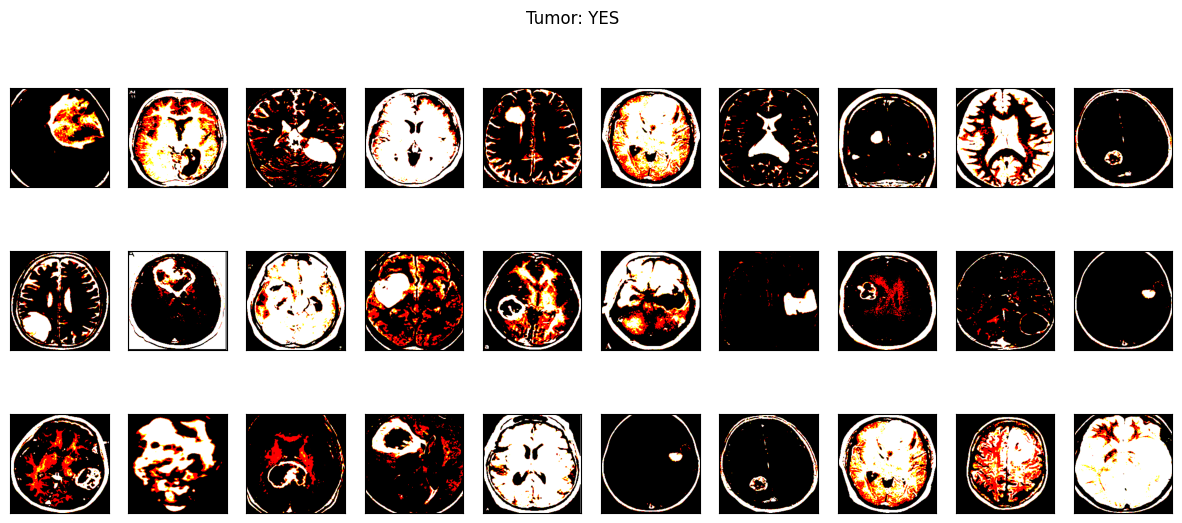

In [19]:
plot_samples(X_train_prep, y_train, labels, 30)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [21]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

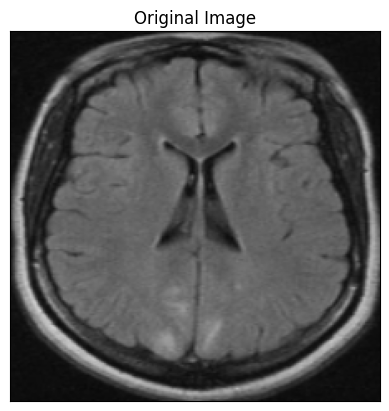

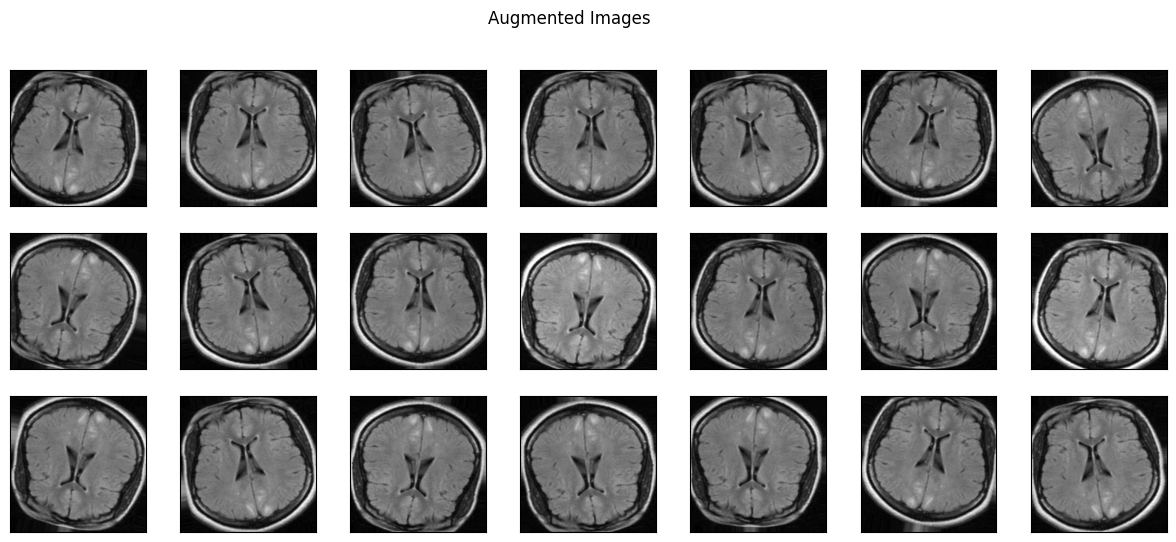

In [22]:
import cv2
import os
import matplotlib.pyplot as plt

plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview/'):
    img = cv2.imread('preview/' + img_name)  # Corrected this line
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [23]:
!rm -rf preview/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



In [24]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [25]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping  # EarlyStopping için import

# Model parametreleri
IMG_SIZE = (299, 299)  # InceptionResNetV2 için önerilen boyut
RANDOM_SEED = 42  # Rastgelelikin kontrolü

# InceptionResNetV2 modelini önceden eğitilmiş ağırlıklarla yükle, son katmanlar dahil edilmiyor
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# Modeli dondur (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Modeli oluşturma
model = Sequential()

# InceptionResNetV2'yi modelimize ekleyelim
model.add(base_model)

# Düzleştirme katmanı
model.add(Flatten())

# Tam bağlı (Fully connected) katmanlar
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout ekleyerek overfitting'i engellemek için

# Çıkış katmanı
model.add(Dense(1, activation='sigmoid'))  # Binary classification için sigmoid

# Modeli derleme
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Model özeti
model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

In [26]:
# Eğitim verisi için veri artırma
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255
)

# Test verisi için yalnızca rescale işlemi yapılır
test_datagen = ImageDataGenerator(rescale=1./255)


# Eğitim ve doğrulama veri jeneratörleri
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

I0000 00:00:1731693467.928852     114 service.cc:145] XLA service 0x7db780004020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731693467.928896     114 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731693467.928900     114 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1731693487.389632     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.4757 - loss: 39.7846 - val_accuracy: 0.6600 - val_loss: 7.2323
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.7304 - loss: 10.4186 - val_accuracy: 0.8000 - val_loss: 3.8461
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.8371 - loss: 5.5868 - val_accuracy: 0.8600 - val_loss: 1.8381
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.8514 - loss: 2.8698 - val_accuracy: 0.9000 - val_loss: 1.2170
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.8640 - loss: 2.5316 - val_accuracy: 0.9000 - val_loss: 1.0074
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - accuracy: 0.8437 - loss: 1.9006 - val_accuracy: 0.8200 - val_loss: 1.9875
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.8317 - loss: 2.0266 - val_accuracy: 0.8600 - val_loss: 0.7343
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.8194 - loss: 1.2673 - val_accuracy: 0.8200 - val_loss: 0.6964
Ep

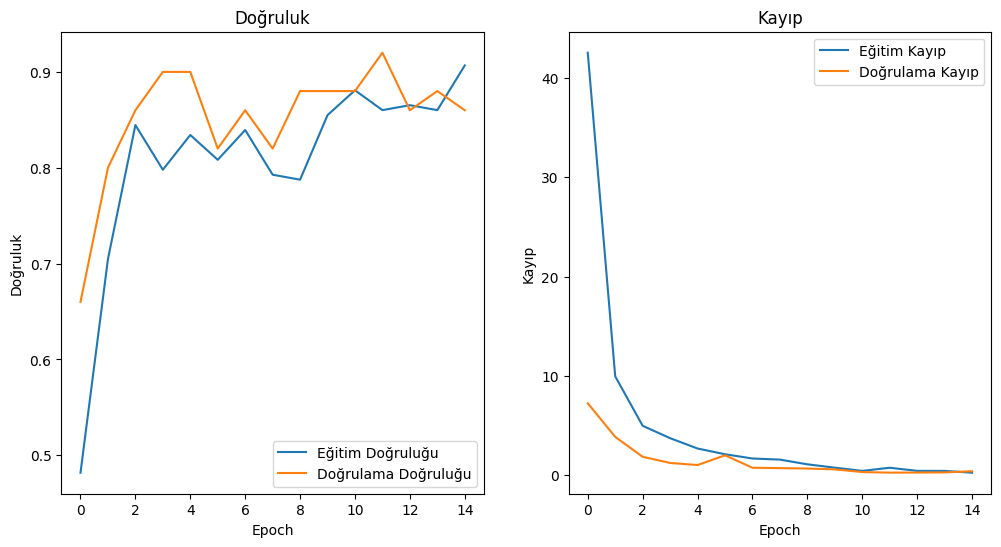

In [27]:
# Eğitim doğruluğu ve kaybı
plt.figure(figsize=(12, 6))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kayıp')
plt.plot(history.history['val_loss'], label='Doğrulama Kayıp')
plt.title('Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

In [28]:
# Modeli kaydetme
model.save('/kaggle/working/cnn_model.h5')


In [29]:
# Test verileri üzerinde değerlendirme
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test Kayıp: {test_loss}, Test Doğruluk: {test_acc}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8877 - loss: 0.3544
Test Kayıp: 0.382669597864151, Test Doğruluk: 0.8600000143051147
